In [195]:
from IPython.core.display import HTML

In this notebook, I am exploring the Meta Kaggle data (https://www.kaggle.com/c/meta-kaggle). The dataset is available in both csv and sqlite database formats.

There are 10 tables:
* Users
* Teams
* TeamMemberships
* Competitions
* Submissions
* CopetitionHostSegments
* RewardTypes
* Sites
* ValidationSets
* EvaluationAlgorithms

# Getting started: import modules and connect to the SQLite database

In [2]:
import pandas as pd
import sqlite3
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [3]:
cnx = sqlite3.connect('database.sqlite')

# Is there any relationship between user ranking and the number of competitions entered?

Let us explore this by plotting the rank vs. number of competitions entered for all users. First, we need a table with these 2 fields. We can construct this by joining the Teams and TeamMemberships tables. 

Pandas has a function *read_sql_query* to execute a SQL query. The output is a data frame with the column names corresponding to sql-table column names. 

In [150]:
rank_vs_ncomps = pd.read_sql_query("""
SELECT U.Ranking AS rank, COUNT(M.TeamId) as num_comps
FROM Users AS U 
JOIN TeamMemberships AS M ON U.Id = M.UserId 
GROUP BY U.Id, U.Ranking
""", cnx) 

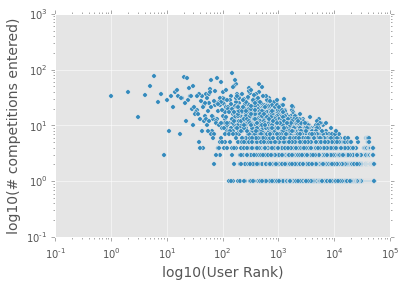

In [154]:
ax = rank_vs_ncomps.plot(x='rank', y='num_comps',   
        logx=True, logy= True, 
        kind='scatter')
ax.set_xlabel('log10(User Rank)', fontsize=14)
ax.set_ylabel('log10(# competitions entered)', fontsize = 14)

We have used the log-log scale for both the x- and y-axes so that we could see more clearly the standing of top-ranking individuals. From this plot, it looked like practice contributes to user standing.

# Do competitions winners work individually or collaboratively?

Let us explore the sizes of all teams that ever took the 1st place in a competition. To do this, we construct a table with team and team size as its fields using the Teams and TeamMemberships tables.

In [77]:
team_top3 = pd.read_sql_query("""
SELECT team_size, rank, COUNT(*) AS num_teams
FROM
(    
    SELECT T.Id AS team_id, T.Ranking AS rank, COUNT(M.UserId) AS team_size
    FROM Teams AS T
    JOIN TeamMemberships AS M ON T.Id = M.TeamId
    WHERE T.Ranking IN (1, 2, 3)
    GROUP BY T.Id, T.Ranking
)
GROUP BY team_size, rank
""", cnx)

In [81]:
team_top3['team_size'] = team_top3['team_size'].map(lambda x : x if (x<5) else 5)

In [125]:
team_top3 = team_top3.groupby(['team_size', 'rank'], as_index=False).sum()

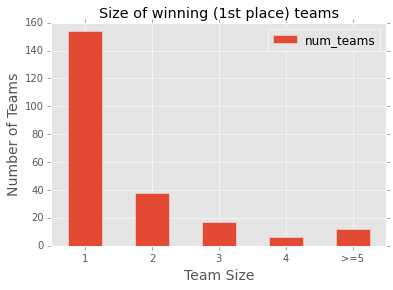

In [141]:
ax = team_top3[team_top3['rank'] == 1].plot(kind='bar', 
                                       x='team_size',
                                       y='num_teams',
                                      title='Size of winning (1st place) teams')
ax.set_xticklabels(['1','2','3','4','>=5'], rotation='horizontal')
ax.set_xlabel('Team Size', fontsize=14)
ax.set_ylabel('Number of Teams', fontsize = 14)

So, most winning teams consisted of only one individual

# Explore the number of registrations by time

Let us plot the number of users by their registration date month-by-month. The data is available in the Users table. We could do this by using SQL queries, but this time, I will do this by manipulating the pandas dataframe. Note the difference in the dataframe returned from sqlite3 and that returned by *pd.read_csv()* 

Get a dataframe from the SQLite Users table :

In [159]:
users_sqlite = pd.read_sql_query("""
SELECT *
FROM Users
""", cnx)

users_sqlite.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365878 entries, 0 to 365877
Data columns (total 8 columns):
Id                365878 non-null int64
UserName          365878 non-null object
DisplayName       365878 non-null object
RegisterDate      365878 non-null object
Points            365878 non-null object
Ranking           365878 non-null object
Tier              365878 non-null int64
HighestRanking    365878 non-null object
dtypes: int64(2), object(6)
memory usage: 16.7+ MB


Compare the previous dataframe with that constructed from the CSV file:

In [182]:
users_csv = pd.read_csv('Users.csv', header=0)
users_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365878 entries, 0 to 365877
Data columns (total 8 columns):
Id                365878 non-null int64
UserName          76141 non-null object
DisplayName       365878 non-null object
RegisterDate      365878 non-null object
Points            51659 non-null float64
Ranking           51659 non-null float64
Tier              365878 non-null int64
HighestRanking    51663 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 20.9+ MB


Note that while *users_csv* indicated columns with missing values, *users_sqlite* did not. It looked like *pd.read_sql_query* fills missing values with an empty string (i.e., ""). The RegisterDate column, however, seems to be complete. In the meantime, let us proceed with our exploration.

First, let us construct another column 'MonYear' which stores only the month and year of registration date:

In [188]:
import re         # a regexp module
users_csv['MonYear'] = users_csv['RegisterDate'].map(lambda x : re.sub(r'([0-9]{4})-([0-9]{2})-([0-9]{2}).*', 
                                                                       r'\1\2', x))

In [189]:
# Get the count of registered users month-by-month
reg_by_monyear = users_csv.groupby('MonYear', as_index=False)['MonYear'].agg({'num' : 'count'})

# From MonYear, construct a column of datetime object called 'Time' - Set the day in the date with 01
reg_by_monyear['Time'] = reg_by_monyear['MonYear'].map(lambda x:
                                             pd.to_datetime(x + '01', format='%Y%m%d'))

Plot the number of new users vs. month/year of registration:

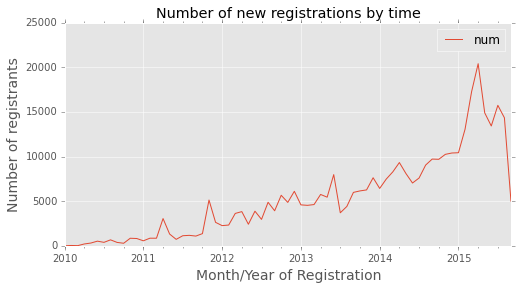

In [194]:
ax = reg_by_monyear.plot(x='Time', y='num', 
                    title = 'Number of new registrations by time',
                    figsize=(8,4))
ax.set_xlabel('Month/Year of Registration', fontsize=14)
ax.set_ylabel('Number of registrants', fontsize = 14)

Note the sharp increase in registration in the first quarter of 2015 (between Jan-Apr 2015). Could this be due to an introduction of Kaggle into the classrooms?